# What is this?

This notebook generates Figure 3-right of the manuscript, as well as Figure 7 in the Appendix.


In [761]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from tensorflow import keras
from tf_multiclass.utils import get_label_manipulators
import tensorflow as tf

n_samples = 1000

X_train, y_train = datasets.make_moons(n_samples=n_samples, noise=0.20)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

n_valid = round(n_samples*0.25)
X_valid = X_train[-n_valid:]
y_valid = y_train[-n_valid:]
X_train = X_train[:-n_valid]
y_train = y_train[:-n_valid]

loss_func = "WW"
use_skip_conn = False
# quantizer = "SteSign"
quantizer = "SwishSign"
hidden_layer_act = "relu"
quantizer_param = None
learning_rate = 0.01
n_features_in = X_train.shape[1]
n_classes=2
n_hyperplanes = 10
n_hidden=1024
dropout_rate = 0.0
opt = keras.optimizers.SGD(learning_rate = learning_rate)



label_encoder, label_decoder, label_predictor, acc_name = get_label_manipulators(loss_func,n_classes)
Y_train = label_encoder(y_train)
Y_valid = label_encoder(y_valid)

In [762]:
from HANN_model import HANN_model_factory

In [763]:
HMF = HANN_model_factory(n_features_in,
    n_classes,
    n_hyperplanes,
    n_hidden,
    use_skip_conn = use_skip_conn,
    dropout_rate = dropout_rate,
    quantizer = "SwishSign",
    hidden_layer_act = hidden_layer_act,
    quantizer_param = None)

In [764]:
model = HMF.get_model(X_train, opt, loss_func=loss_func)
history = model.fit(X_train, Y_train, validation_data=(X_valid,Y_valid), epochs=500, verbose=0,batch_size = 128)

In [765]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np
from PIL import ImageColor


def get_cmp(c1,c2):
    N = 2
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(c1[0]/256, c2[0]/256, N)
    vals[:, 1] = np.linspace(c1[1]/256, c2[1]/256, N)
    vals[:, 2] = np.linspace(c1[2]/256, c2[2]/256, N)
    return ListedColormap(vals)

cbblue_rgb = ImageColor.getcolor("#88BEEC", "RGB")
cbyellow_rgb = ImageColor.getcolor("#FFE9A5", "RGB")
cmp_light = get_cmp(cbblue_rgb, cbyellow_rgb)

cbblue_rgb = ImageColor.getcolor("#0C7BDC", "RGB")
cbyellow_rgb = ImageColor.getcolor("#FFC20A", "RGB")
cmp_dark = get_cmp(cbblue_rgb, cbyellow_rgb)

In [766]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib as mpl
import myplt
from cycler import cycler


lims = myplt.get_plot_lims(X_train)
X_grid = myplt.get_grid(lims,n_grid=200)

In [767]:
from IPython.display import clear_output


def plot_decision_regions(y_grid,lims,ax = None):
    # input:
    #     y_grid = a numpy vector of length n_grid^2 taking values in {0,1,...,n_classes-1}
    #     lims = [xmin, xmax, ymin, ymax], e.g., the output of 'get_plot_lims'
    
    # plot the decision regions of y_grid, 
    # it is expected that y_grid is a list of length n_grid^2
    
    if ax is None:
        ax = plt.gca()
    n_grid = int(np.sqrt(y_grid.shape[0]))
    Z = (y_grid.reshape((n_grid,n_grid)))
    ax.contourf(Z,
                extent = lims,
                levels=1,
#                 cmap='bone',
                cmap=cmp_light, vmin=0,
                vmax=1)

def plot_model_decision_region(model, X_pts, y_pts, X_grid,ax = None, **kwargs):
    clear_output(wait = True)
    if ax is None:
        ax = plt.gca()
    y_pred = label_predictor(model(X_pts,training=False)).numpy()
    y_grid = label_predictor(model(X_grid,training=False)).numpy()
    plot_decision_regions(y_grid,lims,ax)
    
    weights = model.weights[0].numpy()
    biases = model.weights[1].numpy()

    myplt.plot_hyperplanes(weights,biases,ax)
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    
    ax.scatter(X_pts[:,0], X_pts[:,1], c = y_pts, edgecolors='k', **kwargs)
    ax.set_xlim(lims[0], lims[1])
    ax.set_ylim(lims[2], lims[3])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])



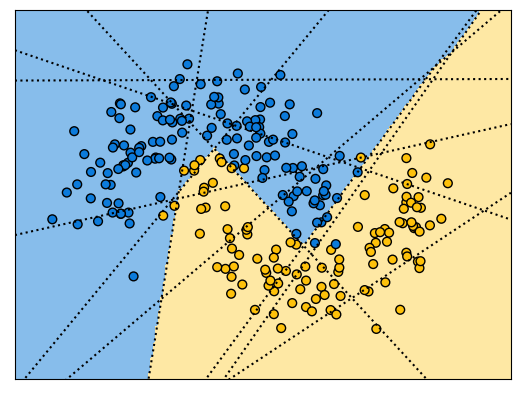

In [769]:
# pts_show = np.random.choice(X_train.shape[0], 200)
plot_model_decision_region(model,X_valid, y_valid,X_grid, vmin=-0.8, s=40,cmap = cmp_dark)
savefig('figures/decision_regions.eps',bbox_inches='tight')
plt.show()

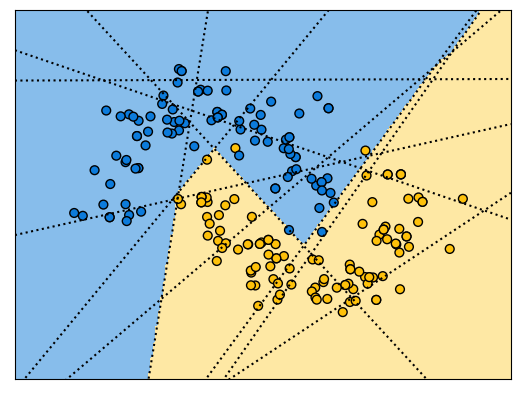

In [770]:
pts_show = np.random.choice(X_train.shape[0], 200)

plot_model_decision_region(model,X_train[pts_show,:], y_train[pts_show],X_grid, vmin=-0.8, s=40,cmap=cmp_dark)
savefig('figures/decision_regions_trn_trimmed.eps',bbox_inches='tight')
plt.show()

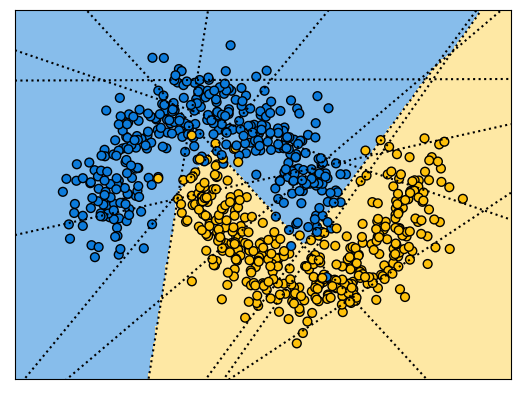

In [771]:

plot_model_decision_region(model,X_train, y_train,X_grid, vmin=-0.8, s=40,cmap=cmp_dark)
savefig('figures/decision_regions_trn_full.png',bbox_inches='tight')
plt.show()

In [772]:
from hyperplane_arrangement.IncEnu import incremental_enumeration

In [773]:
weights = model.weights[0].numpy()
biases = model.weights[1].numpy()

import time
start_time = time.perf_counter()
sign_vectors, interior_points =  incremental_enumeration(weights,biases)
print(time.perf_counter() - start_time)

Iteration: 2 / 10
Number of cells: 4
Iteration: 3 / 10
Number of cells: 7
Iteration: 4 / 10
Number of cells: 11
Iteration: 5 / 10
Number of cells: 16
Iteration: 6 / 10
Number of cells: 22
Iteration: 7 / 10
Number of cells: 29
Iteration: 8 / 10
Number of cells: 37
Iteration: 9 / 10
Number of cells: 46
Iteration: 10 / 10
Number of cells: 56
1.3356339633464813


In [774]:
weights = model.weights[0].numpy()
biases = model.weights[1].numpy()
MaxAbsVal = 4

sign_vectors, interior_points =  incremental_enumeration(weights,biases,MaxAbsVal)

Iteration: 2 / 10
Number of cells: 4
Iteration: 3 / 10
Number of cells: 7
Iteration: 4 / 10
Number of cells: 11
Iteration: 5 / 10
Number of cells: 15
Iteration: 6 / 10
Number of cells: 20
Iteration: 7 / 10
Number of cells: 27
Iteration: 8 / 10
Number of cells: 33
Iteration: 9 / 10
Number of cells: 39
Iteration: 10 / 10
Number of cells: 45


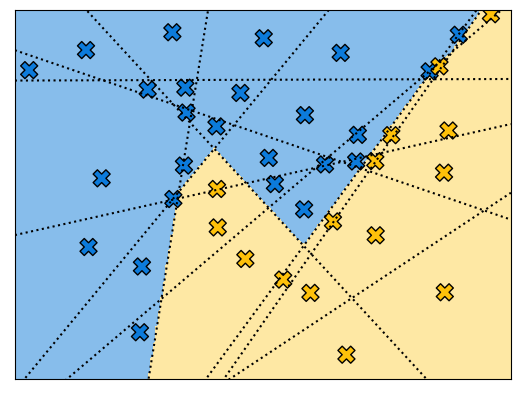

In [775]:
X_pts = interior_points
y_pts = label_predictor(model(interior_points))
plot_model_decision_region(model,X_pts, y_pts,X_grid,marker="X",s=150,cmap =cmp_dark)
savefig('figures/cell_enum.eps',bbox_inches='tight')
plt.show()

In [776]:
Ws = model.get_weights()
W = Ws[0]
b = Ws[1]

In [777]:
def to_sign_vectors(x,W,b):
    return ((np.sign(np.matmul(x,W)+b)+1)/2).astype(int)

def svlist_to_svstr(svlist):
    return ["".join(map(str,l)) for l in svlist]

def to_svstr(x,W,b):
    return svlist_to_svstr(to_sign_vectors(x,W,b))

def hamming_dist(s1,s2):
    return sum([0 if s1[i] == s2[i] else 1 for i in range(len(s1))])
hamming_dist("a","b")

1

In [778]:
svstr_train = to_svstr(X_train,W,b)
svstr_interior = to_svstr(interior_points,W,b)
sv_interior = to_sign_vectors(interior_points,W,b)
interior_labels = label_predictor(model(interior_points)).numpy().astype(int)

# neighborhood of a sign pattern
# is the set of sign patterns that are exactly 1 flip away
# i.e., the Hamming distance is 1
neighbors = [[t for t in svstr_interior if hamming_dist(s,t)==1] for s in svstr_interior]

In [779]:
import pandas as pd

lut = pd.DataFrame(zip(svstr_interior, 2*sv_interior-1,interior_labels, neighbors),
                   columns = ["sign_pattern","sign_vector", "label", "neighbors"]).set_index('sign_pattern')


# neighborhood labels
nbhd_labels = [lut.loc[lut.loc[s,"neighbors"], "label"].tolist() for s in svstr_interior]

# nbhd_purity
# do all the neighbors have the same labels?
nbhd_purity = [len(set(l))==1 for l in nbhd_labels]



lut["nbhd_labels"] = nbhd_labels
lut["nbhd_rnd_label"] = [l[0] for l in nbhd_labels]
lut["nbhd_purity"] = nbhd_purity

In [780]:
from pypoman import compute_polytope_vertices
from matplotlib.patches import Polygon
import math


def get_vertices_for_region(s,W,b,MaxAbsVal):
    M = MaxAbsVal
    sW = -np.expand_dims(s, axis = 1) * W.T
    sb = s*b
    I = np.eye(2)
    A_poly = np.vstack([sW,I,-I])
    b_poly = np.concatenate([sb,np.array([M,M,M,M])])
    vertices = np.vstack(compute_polytope_vertices(A_poly, b_poly))
    return circle_sort(vertices)


def circle_sort(vertices):
    # sort a set of vertices by their angle w.r.t to the centroid
    centroid = np.mean(vertices,axis=0)
    vtx_centered = vertices-centroid
    angles = np.array(list(map(lambda v : math.atan2(v[1],v[0]), vtx_centered)))
    return vertices[np.argsort(angles),:]


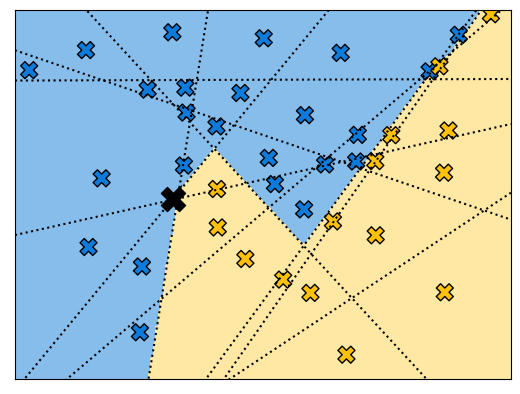

In [781]:
i = 4

s = lut.iloc[i]['sign_vector']

vtx = get_vertices_for_region(s,W,b,MaxAbsVal)
p = Polygon(vtx, facecolor = 'k',lw=3, fill=False)


X_pts = interior_points
y_pts = label_predictor(model(interior_points))

plot_model_decision_region(model,X_pts, y_pts,X_grid,marker="X",s=150,cmap =cmp_dark)
plt.scatter(interior_points[i,0], interior_points[i,1], edgecolors='k', facecolors='k', marker="X",s=300)
ax = plt.gca()
ax.add_patch(p)
plt.show()

In [782]:
keys,vals = np.unique(svstr_train,return_counts=True)
count_dict = dict(zip(keys,vals))

In [783]:
region_counts = [(0 if k not in count_dict.keys() else count_dict[k]) for k in svstr_interior]
lut['trn_counts'] = region_counts
lut['empty'] = (lut['trn_counts']==0).tolist()

In [784]:
# keep = (lut['trn_counts']==0 & lut['nbhd_purity']).tolist()
keep = (lut['trn_counts']==0).tolist()

In [785]:
keep = np.logical_and(lut['empty'], lut['nbhd_purity']).tolist()

# Is there any enclaves?

In [786]:
# Cells that are both empty (no training points) and also has pure neighborhoods
A = np.logical_and(lut['empty'].tolist(), lut['nbhd_purity'].tolist())
# Cells that have different labels from its neighbors
B = (lut['nbhd_rnd_label'] != lut['label']).tolist()
# Any enclaves?
np.any(np.logical_and(A,B))

False

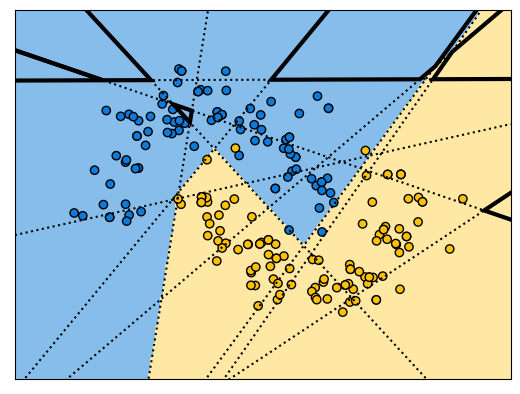

In [787]:
X_pts = interior_points
y_pts = label_predictor(model(interior_points))

plot_model_decision_region(model,X_train[pts_show,:], y_train[pts_show],X_grid,cmap =cmp_dark)
ax = plt.gca()
for i in  list(np.where(np.array(keep))[0]):
    s = lut.iloc[i]['sign_vector']

    vtx = get_vertices_for_region(s,W,b,MaxAbsVal)
    p = Polygon(vtx, facecolor = 'k',lw=3, fill=False)
    ax.add_patch(p)
savefig('figures/moons.eps',bbox_inches='tight')

plt.show()